In [2]:
import pandas as pd
import seaborn as sns
import glob
import os
import janitor
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

Text(0.5, 1.0, 'CryoSat-2 - Inclination')

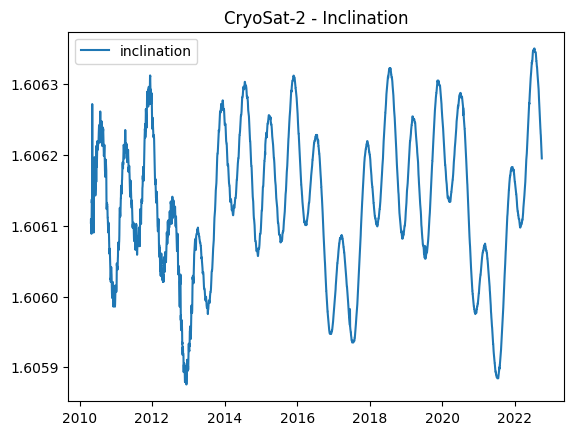

In [4]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_CryoSat-2.csv"

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path, index_col = 0, parse_dates = True)

# Creating a dataframe with only the Inclination
df_bmm = df[["inclination"]]

# Plotting the Brouwer Mean Motion
sns.lineplot(data = df_bmm)
plt.title("CryoSat-2 - Inclination")

In [5]:
# Defining the format of the maneuver text file
columns_widths = [
    (0,5),      # Satellite Name
    (6,10),     # Begining of manueuver year    
    (11,14),    # Begining of manueuver day       
    (15,17),    # Begining of manueuver hour 
    (18,20),    # Begining of manueuver minute 
    (21,25),    # End of manueuver year 
    (26,29),    # End of manueuver day 
    (30,32),    # End of manueuver hour 
    (33,35),    # End of manueuver minute 
    (36,39),    # Manuever type
    (40,43),    # Manuever parameter type
    (44,45)     # Number of burns
]

# Function to parse each line based on column widths defined
def parse_line(line):
    data = [
        line[start:end].strip()
        for start, end in columns_widths
    ]
    return data

# Function to convert start and end maneuver to datetime
def convert_to_datetime(row):
    start_date = datetime.strptime(f"{row['Start_Year']} {row['Start_Day']} {row['Start_Hour']} {row['Start_Minute']}", "%Y %j %H %M")
    end_date = datetime.strptime(f"{row['End_Year']} {row['End_Day']} {row['End_Hour']} {row['End_Minute']}", "%Y %j %H %M")
    return start_date, end_date

# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/cs2man.txt'

# Reading the text file into a list of lines
with open(maneuver_file_path, 'r') as txt_file:
    lines = txt_file.readlines()

# Parsing each line into a list of values
parsed_data = [parse_line(line) for line in lines]

# Defining the column names
column_names = [
    'Satellite', 'Start_Year', 'Start_Day', 'Start_Hour', 'Start_Minute',
    'End_Year', 'End_Day', 'End_Hour', 'End_Minute',
    'Maneuver_Type', 'Parameter_Type', 'Number_of_Burns'
]

# Creating a dataframe with the text file data
df = pd.DataFrame(parsed_data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'], df['End_Date'] = zip(*df.apply(convert_to_datetime,axis=1))

# Checking the dataframe
print(df.head())

  Satellite Start_Year Start_Day Start_Hour Start_Minute End_Year End_Day  \
0     CRYO2       2010       105         17           47     2010     105   
1     CRYO2       2010       123         17           55     2010     124   
2     CRYO2       2010       124         18           38     2010     124   
3     CRYO2       2010       125         17           44     2010     125   
4     CRYO2       2010       126         18           26     2010     126   

  End_Hour End_Minute Maneuver_Type Parameter_Type Number_of_Burns  \
0       17         48                          006               1   
1       00         35                          006               2   
2       18         48                          006               1   
3       17         59                          006               1   
4       18         51                          006               1   

           Start_Date            End_Date  
0 2010-04-15 17:47:00 2010-04-15 17:48:00  
1 2010-05-03 17:55:00 2010-0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

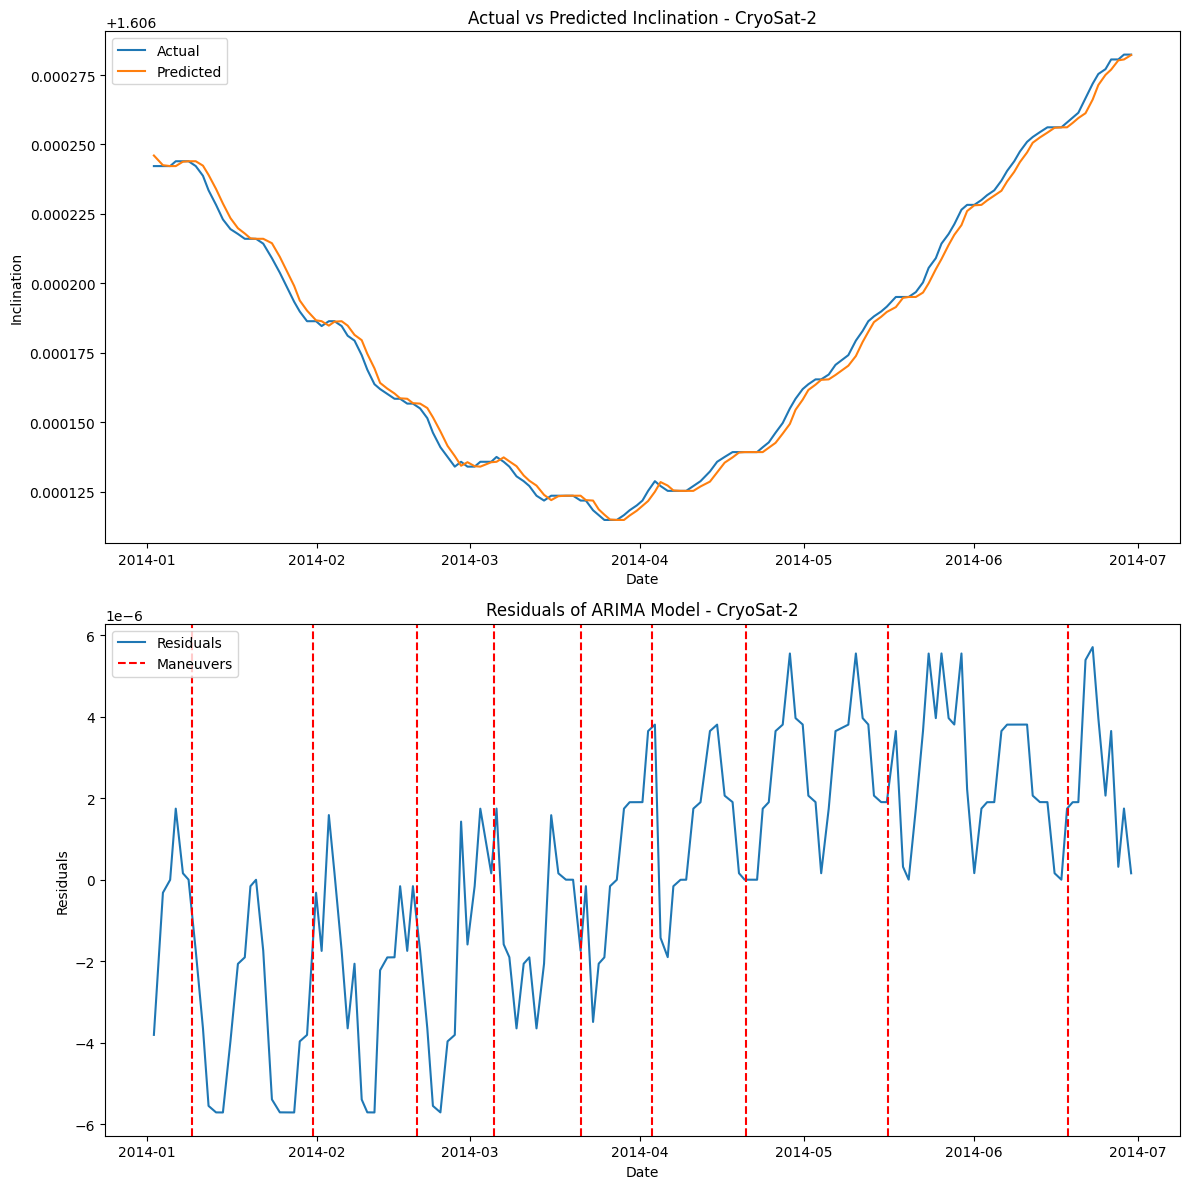

In [6]:
# Fitting an ARIMA model to the entire dataset
arima_model = ARIMA(df_bmm,order = (1,1,0))
arima_model_fit = arima_model.fit()

# Making predictions
predictions = arima_model_fit.predict(start = 0, end = len(df_bmm) - 1, typ = 'levels')

# Calculating residuals
residuals = df_bmm['inclination'] - predictions

# Defining date ranges
start_date = pd.to_datetime("2014-01-01")
end_date = pd.to_datetime("2014-06-30")

# Filtering the actual, predictions and residuals based on the date range
actual_filtered = df_bmm[start_date:end_date]
predictions_filtered = predictions[start_date:end_date]
residuals_filtered = residuals[start_date:end_date]

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize = (12,12))

# Plotting actual vs predicted values
sns.lineplot(x = actual_filtered.index, y = actual_filtered["inclination"], label = "Actual", ax = axes[0])
sns.lineplot(x = predictions_filtered.index, y = predictions_filtered, label = "Predicted", ax = axes[0])
axes[0].set_title("Actual vs Predicted Inclination - CryoSat-2")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Inclination")
axes[0].legend()

# Plotting residuals
sns.lineplot(x = residuals_filtered.index, y = residuals_filtered, label = "Residuals", ax = axes[1])
axes[1].set_title("Residuals of ARIMA Model - CryoSat-2")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Residuals")

# Filtering maneuvers based on the date range
maneuvers_filtered = df[df["Start_Date"] >= start_date]
maneuvers_filtered = maneuvers_filtered[maneuvers_filtered["Start_Date"] <= end_date]

# Marking maneuvers on the residuals plot
maneuver_dates = maneuvers_filtered['Start_Date']
first_label = True
for maneuver_date in maneuver_dates:
    if first_label:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--', label = "Maneuvers")
        first_label = False
    else:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--')     
axes[1].legend()

plt.tight_layout()
plt.show()